In [1]:
import pandas as pd
import xarray as xr
import matplotlib.gridspec as gridspec
import dask
from dask import delayed, compute
from itertools import product
from importlib import reload
from functools import partial

Matplotlib created a temporary cache directory at /jobfs/136598666.gadi-pbs/matplotlib-68jt2adm because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import my_stats
import toe_calc
import toe_calc_variations
import toe_constants as toe_const

In [3]:
import toe_plots

In [4]:
xr.set_options(display_expand_data=False)

In [5]:
from dask.distributed import wait

In [6]:
from dask.distributed import Client
# client.close()  # Close existing client
client = Client(n_workers=50, threads_per_worker=1, memory_limit=None)
client

 - State start
 - Found stale lock file and directory '/jobfs/136598666.gadi-pbs/dask-scratch-space/scheduler-aqc_1pnk', purging
 -   Scheduler at:     tcp://127.0.0.1:39765
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:43951'
 -         Start Nanny at: 'tcp://127.0.0.1:44519'
 -         Start Nanny at: 'tcp://127.0.0.1:39283'
 -         Start Nanny at: 'tcp://127.0.0.1:43551'
 -         Start Nanny at: 'tcp://127.0.0.1:40033'
 -         Start Nanny at: 'tcp://127.0.0.1:41965'
 -         Start Nanny at: 'tcp://127.0.0.1:43483'
 -         Start Nanny at: 'tcp://127.0.0.1:37979'
 -         Start Nanny at: 'tcp://127.0.0.1:46097'
 -         Start Nanny at: 'tcp://127.0.0.1:41059'
 -         Start Nanny at: 'tcp://127.0.0.1:45659'
 -         Start Nanny at: 'tcp://127.0.0.1:42071'
 -         Start Nanny at: 'tcp://127.0.0.1:39175'
 -         Start Nanny at: 'tcp://127.0.0.1:46035'
 -         Start Nanny at: 't

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 50
Total threads: 50,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39765,Workers: 50
Dashboard: /proxy/8787/status,Total threads: 50
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40181,Total threads: 1
Dashboard: /proxy/38531/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43951,


 - Event loop was unresponsive in Nanny for 23.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 23.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 23.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 23.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 23.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 23.30s.  This is often caused b

In [7]:
np.random.gamma
np.random.weibull
import scipy
scipy.stats.genextreme.rvs#(c, loc, scale, size)
# np.random.lognormal(mean, sigma, size)

<bound method rv_generic.rvs of <scipy.stats._continuous_distns.genextreme_gen object at 0x150ae1afbe20>>

In [8]:
import numpy as np
from scipy.signal import lfilter

def generate_red_noise(size=100, std=0.2, alpha=0):
    """
    Generates red noise (AR(1) process) with a specified standard deviation.

    Parameters:
    size (int): Length of the generated red noise sequence (default: 100).
    std (float): Desired standard deviation of the output red noise (default: 0.2).
    alpha (float): Autoregressive parameter (default: 0, which gives white noise).

    Returns:
    np.ndarray: Red noise sequence with the specified standard deviation.
    """

    # Generate standard normal white noise
    noise = np.random.normal(0, std, size)
    
    # Apply AR(1) filter to introduce autocorrelation
    if alpha: noise = lfilter([1], [1, -alpha], noise)
        
    # Normalize the output to match the desired standard deviation
    noise = noise / np.std(noise) * std
    return noise


In [9]:
def non_stationary_noise(arr: np.ndarray, start_std: float, end_std: float, window: int) -> np.ndarray:
    """
    Apply a linearly varying noise multiplier to an array.

    The function scales the input array using a smoothly increasing 
    standard deviation multiplier. The standard deviation starts at 
    a lower value and linearly increases, reaching `start_std` at 
    index `window//2` and `end_std` at `len(arr) - window//2`.

    Parameters:
    -----------
    arr : np.ndarray
        Input array to be scaled.
    start_std : float
        Standard deviation multiplier at index `window//2`.
    end_std : float
        Standard deviation multiplier at index `len(arr) - window//2`.
    window : int
        Defines the range within which the standard deviation scaling begins and ends.

    Returns:
    --------
    np.ndarray
        Scaled array with non-stationary noise applied.
    """

    n = len(arr)
    start_idx = window // 2
    end_idx = n - window // 2

    std_mult_series = np.linspace(
        start_std - (start_idx / (end_idx - start_idx)) * (end_std - start_std),
        end_std + ((n - end_idx) / (end_idx - start_idx)) * (end_std - start_std),
        n
    )

    return arr * std_mult_series

In [10]:
sample_ts = generate_red_noise(300, 1, 0)

In [11]:
sample_ts_new = non_stationary_noise(sample_ts, start_std=0.1, end_std=1, window=30)

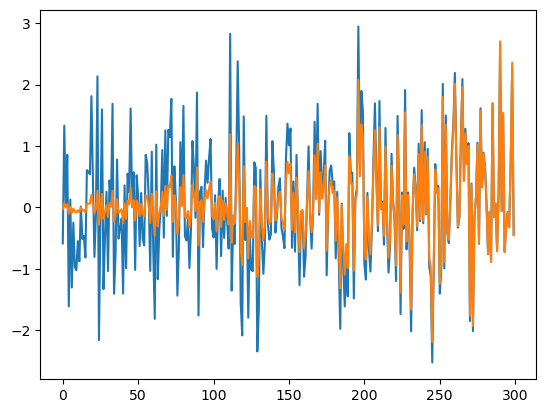

In [12]:
plt.plot(sample_ts)
plt.plot(sample_ts_new)

In [13]:
std_list = np.arange(0.1, 0.5, 0.1)
rho_list = np.arange(0.1, 0.5, 0.1)

for std, rho in product(std_list, rho_list):
    output_std = np.std(generate_red_noise(300, std, rho))
    print(f'{std=:.2f} - {rho=:.2f} - {output_std:.2f} - ({(std-output_std):.2f})')


std=0.10 - rho=0.10 - 0.10 - (0.00)
std=0.10 - rho=0.20 - 0.10 - (0.00)
std=0.10 - rho=0.30 - 0.10 - (-0.00)
std=0.10 - rho=0.40 - 0.10 - (-0.00)
std=0.20 - rho=0.10 - 0.20 - (0.00)
std=0.20 - rho=0.20 - 0.20 - (0.00)
std=0.20 - rho=0.30 - 0.20 - (0.00)
std=0.20 - rho=0.40 - 0.20 - (-0.00)
std=0.30 - rho=0.10 - 0.30 - (0.00)
std=0.30 - rho=0.20 - 0.30 - (-0.00)
std=0.30 - rho=0.30 - 0.30 - (0.00)
std=0.30 - rho=0.40 - 0.30 - (0.00)
std=0.40 - rho=0.10 - 0.40 - (0.00)
std=0.40 - rho=0.20 - 0.40 - (0.00)
std=0.40 - rho=0.30 - 0.40 - (0.00)
std=0.40 - rho=0.40 - 0.40 - (0.00)


In [14]:
def generate_base_noise(distribution, **kwargs):
    """
    Returns a pre-configured noise generation function with fixed parameters.

    Parameters:
    distribution (str): The distribution to slog in as the base noise source.
    **kwargs: Additional parameters required for each distribution.

    Returns:
    function: A function that generates noise samples when called.
    """

    if distribution == "normal": return partial(np.random.normal, **kwargs)
    elif distribution == "gamma": return partial(np.random.gamma, **kwargs)
    elif distribution == "lognormal": return partial(np.random.lognormal, **kwargs)
    elif distribution == "weibull": return partial(np.random.weibull, **kwargs)
    elif distribution == "exponential": return partial(np.random.exponential, **kwargs)
    elif distribution == "gumbel": return partial(np.random.gumbel, **kwargs)
    elif distribution == "poisson": return partial(np.random.poisson, **kwargs)
    else:
        raise ValueError(
            "Unsupported distribution type. Choose from: normal, gamma, lognormal, weibull, exponential, gumbel, poisson."
        )

In [15]:
def generate_noise_process(size, alpha, noise_func):
    """
    Generates an autocorrelated noise process (AR(1) process) using a given noise function.

    Parameters:
    size (int): Length of the generated noise sequence.
    alpha (float): Autoregressive parameter (0 gives uncorrelated noise).
    noise_func (function): Pre-configured function to generate noise samples.

    Returns:
    np.ndarray: Noise process sequence with the specified autocorrelation.
    """
    
    # Generate noise using the pre-configured function
    base_noise = noise_func(size)

    # Apply AR(1) filter to introduce autocorrelation
    noise_process = lfilter([1], [1, -alpha], base_noise)

    # Normalize the output to match the original standard deviation
    noise_process = noise_process / np.std(noise_process) * np.std(base_noise)

    return noise_process

In [14]:
# # Create a noise generator with specific parameters
# gamma_noise = generate_base_noise("gamma", shape=2, scale=0.5)
# lognormal_noise = generate_base_noise("lognormal", mean=0, sigma=0.3)

# # Use it in the AR(1) noise process
# gamma_series = generate_noise_process(size=1000, alpha=0.8, noise_func=gamma_noise)
# lognormal_series = generate_noise_process(size=1000, alpha=0.5, noise_func=lognormal_noise)


<h1 style='color:cyan'> Single Ensemble </h1>

In [15]:
np.random.seed(51)

# Generate time series
n = 150  # Number of time points
base_period = np.tile(0, 30)
grad = 1.2/130 # 1.2 degree change since 1850
trend_line = grad * np.arange(150)  # Linear trend

true_trend = np.concatenate([base_period, trend_line])
t = np.arange(len(true_trend))

In [16]:
base_noise = generate_red_noise(len(true_trend), 0.25, 0.3)
base_noise.shape, true_trend.shape

((180,), (180,))

In [17]:
num_iterations = 4

In [18]:
# Generate iterations

In [19]:
# Define the iterations coordinate
iterations = np.arange(1, num_iterations + 1)

# Compute noisy signals (vectorized)
noisy_signals = true_trend + np.outer(iterations, base_noise)

# Convert to xarray DataArray
noisy_series_xr = xr.DataArray(
    noisy_signals,
    dims=( "noise_index","time"),  # Using 'noise_index' as requested
    coords={"noise_index": np.arange(num_iterations),  "time": t}
)

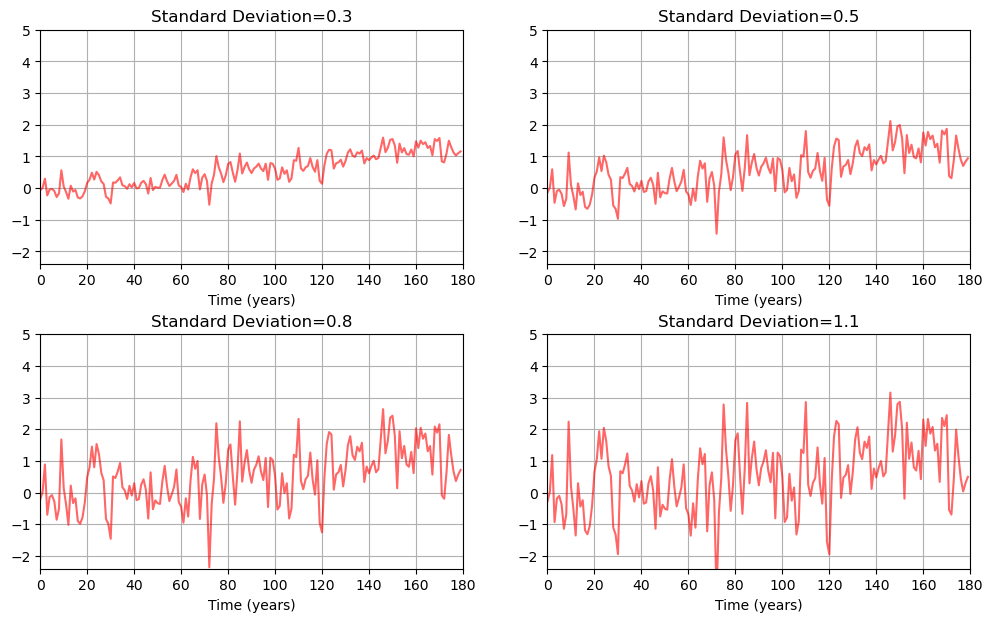

In [20]:
nrows = 2
ncols = 2
num_plot = nrows*ncols


fig = plt.figure(figsize=(6*nrows, 3.5*ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.3)
axes = [fig.add_subplot(gs[i]) for i in range(num_plot)]

time = noisy_series_xr.time.values

for i in np.arange(num_iterations):

    noisy_series = noisy_series_xr.sel(noise_index=i).values

    
    axes[i].plot(time, noisy_series, color='red', alpha=0.6)
    # axes[i].plot(t, true_trend, linestyle='dashed', color='black', label='True Trend')
    
    axes[i].set_title(f'Standard Deviation={np.std(noisy_series[:30]):.1f}')
    # axes[i].legend()
    axes[i].grid(True)

    axes[i].set_xlim(0, len(time))
    axes[i].set_ylim(-2.4, 5)
    
# axes[0].set_ylabel('Value')
for ax in axes:
    ax.set_xlabel('Time (years)')

# plt.tight_layout()

In [21]:
signal_df = xr.apply_ufunc(
    my_stats.apply_lowess,
    noisy_series_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

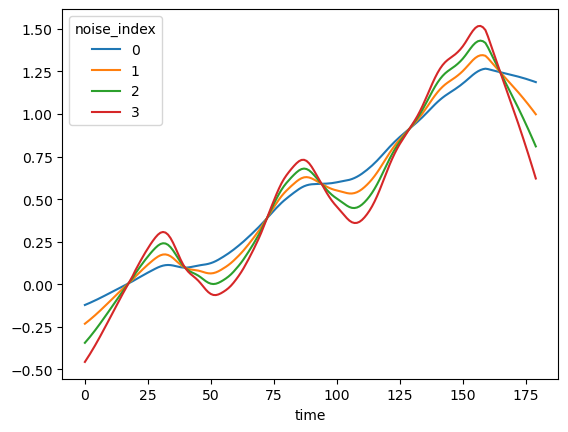

In [22]:
signal_df.plot(hue='noise_index');

In [23]:
noise_df = noisy_series_xr.isel(time=slice(0,30)).std(dim='time')
noise_df

<xarray.DataArray (noise_index: 4)> Size: 32B
array([0.26366141, 0.52732283, 0.79098424, 1.05464566])
Coordinates:
  * noise_index  (noise_index) int64 32B 0 1 2 3

In [24]:
sn_df = signal_df/noise_df

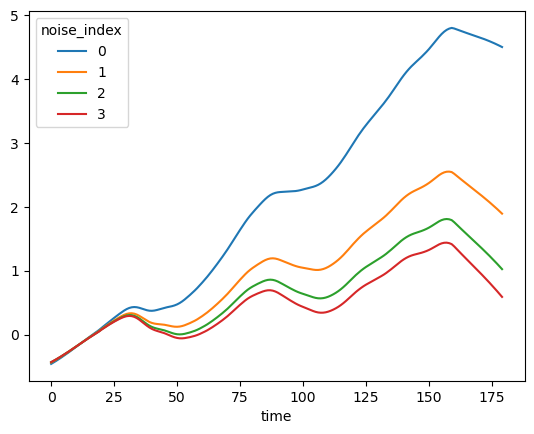

In [25]:
sn_df.plot(hue='noise_index');

<h1 style='color:cyan'> Variable Definitions </h1>

In [16]:
def generate_noise_ensemble(std: float, rho: float, num_trials: int = 200, 
                            atol: float = None, rtol: float = None, length: int = 100, 
                            batch_size: int = 100):
    """
    Generate an ensemble of red noise series with a specified standard deviation in parallel batches.

    Parameters:
    - std: Target standard deviation of the noise series.
    - rho: Autoregressive coefficient for red noise.
    - num_trials: Number of noise series to generate.
    - atol: Absolute tolerance for matching the desired standard deviation.
    - rtol: Relative tolerance for matching the desired standard deviation.
    - length: Length of each noise series.
    - batch_size: Number of noise series processed in a single batch.

    Returns:
    - A NumPy array containing the noise ensemble.
    """

    if atol is None and rtol is None:
        atol = 0.05 * std
    elif rtol is not None:
        atol = rtol * std

    print(f'\n{std=} - {rho=} - {length=} - {atol=}\n')

    @delayed
    def generate_batch():
        """ Generate a batch of red noise and filter valid samples. """
        samples = np.array([generate_red_noise(length, std, rho) for _ in range(batch_size)])
        stds = np.std(samples, axis=1)
        valid_samples = samples[(stds > (std - atol)) & (stds < (std + atol))]
        print(f'len - {len(valid_samples)}')
        return valid_samples

    collected_samples = []
    to_compute = []

    
    batch_num = 0  # Track batch number
    while len(collected_samples) < num_trials:
        batch_num += 1
        print(f"{batch_num} ({len(collected_samples)}), ", end='')  # Print batch number
    
        batch = generate_batch()  # Create delayed task
        valid_samples = compute(batch)[0]  # Compute after each batch
        
        collected_samples.extend(valid_samples)

        # # Stop if we have enough samples
        # if len(collected_samples) >= num_trials:
        #     break

    # Trim to exactly `num_trials`
    noise_series_arr = np.array(collected_samples[:num_trials])

    # Convert to xarray
    noise_bs_xr = xr.DataArray(
        noise_series_arr,
        dims=("iteration", "time"),
        coords={"iteration": np.arange(num_trials), "time": np.arange(length),
               'rho': rho, 'std': std}
    ).chunk({'iteration':'auto', 'time':-1})


    return noise_bs_xr

In [17]:
base_period_length = 30
window = 30

In [18]:
base_period = np.tile(0, base_period_length)
grad = 1.2/140 # 1.2 degree change since 1850
trend_line = grad * np.arange(470)  # Linear trend

true_trend = np.concatenate([base_period, trend_line])
true_trend.shape

(500,)

In [19]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

In [20]:
x = np.linspace(0, true_trend.shape[0], 2000)

In [21]:
kde_create_kwargs = dict(
    input_core_dims=[['iteration']],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=[float]
)

<h1 style='color:cyan'> Bootstrap</h1>

<h2 style='color:yellow'> Generating Data </h2>

In [22]:
std_values = [0.1, 0.25, 0.5, 0.75, 1]
rho_values = [0, 0.25, 0.5, 0.75]

# First, concatenate along std
std_concat_list = []
for std in std_values:
    rho_concat_list = [
        generate_noise_ensemble(
            std, rho, length=true_trend.shape[0],
            rtol=0.2, num_trials=10000)
        for rho in rho_values]
    std_concat_list.append(xr.concat(rho_concat_list, dim="rho"))

# Then, concatenate along rho
noise_ensemble_da = xr.concat(std_concat_list, dim="std")


std=0.1 - rho=0 - length=500 - atol=0.020000000000000004

1 (0), 2 (100), 3 (200), 4 (300), 5 (400), 6 (500), 7 (600), 8 (700), 9 (800), 10 (900), 11 (1000), 12 (1100), 13 (1200), 14 (1300), 15 (1400), 16 (1500), 17 (1600), 18 (1700), 19 (1800), 20 (1900), 21 (2000), 22 (2100), 23 (2200), 24 (2300), 25 (2400), 26 (2500), 27 (2600), 28 (2700), 29 (2800), 30 (2900), 31 (3000), 32 (3100), 33 (3200), 34 (3300), 35 (3400), 36 (3500), 37 (3600), 38 (3700), 39 (3800), 40 (3900), 41 (4000), 42 (4100), 43 (4200), 44 (4300), 45 (4400), 46 (4500), 47 (4600), 48 (4700), 49 (4800), 50 (4900), 51 (5000), 52 (5100), 53 (5200), 54 (5300), 55 (5400), 56 (5500), 57 (5600), 58 (5700), 59 (5800), 60 (5900), 61 (6000), 62 (6100), 63 (6200), 64 (6300), 65 (6400), 66 (6500), 67 (6600), 68 (6700), 69 (6800), 70 (6900), 71 (7000), 72 (7100), 73 (7200), 74 (7300), 75 (7400), 76 (7500), 77 (7600), 78 (7700), 79 (7800), 80 (7900), 81 (8000), 82 (8100), 83 (8200), 84 (8300), 85 (8400), 86 (8500), 87 (8600), 88 (8

In [23]:
true_trend.shape

(500,)

In [24]:
noise_ensemble_da

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

In [25]:
trend_bs_xr = noise_ensemble_da + true_trend

In [26]:
trend_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


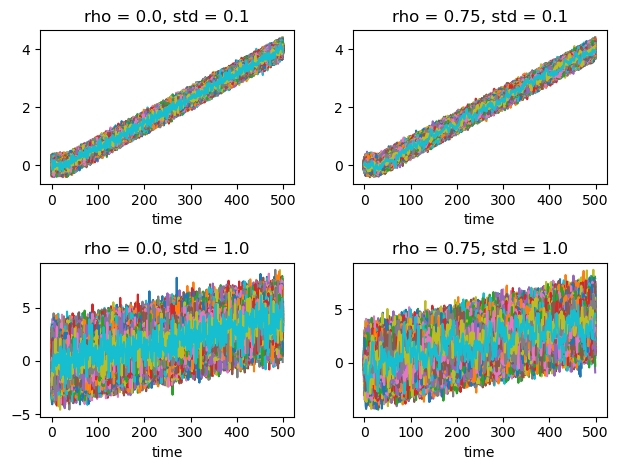

In [27]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

trend_bs_xr.sel(std=0.1, rho=0).plot(ax=axes[0], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=0.1, rho=0.75).plot(ax=axes[1], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=1, rho=0).plot(ax=axes[2], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=1, rho=0.75).plot(ax=axes[3], hue='iteration', add_legend=False);

plt.tight_layout()

<h2 style='color:yellow'> ToE Calclulation </h2>

In [56]:
data_ds_window = (trend_bs_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (trend_bs_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window);
wait(base_period_window_ds);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 763.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [57]:
trend_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

### KS and Overlap

In [58]:
# # The arguements needed for all of the calculations
# rolling_window_kwargs = dict(
#     input_core_dims=[['window_dim'], ['window_dim']],
#     exclude_dims={'window_dim'},
#     vectorize=True,
#     dask='parallelized')

In [59]:
# %%time
# # Expected 3 minutes 30 seconds - best
# # 6 23 - era5
# ks_ds = xr.apply_ufunc(
#         toe_calc.return_ks_pvalue,
#         data_ds_window,
#         base_period_window_ds,
#     **rolling_window_kwargs
#     ).compute()

CPU times: user 5min 10s, sys: 1min 2s, total: 6min 13s
Wall time: 21min 48s


In [ ]:
ks_ds = toe_calc_variations.ks(data_ds_window, base_period_window_ds)

In [60]:
# import toe_calc_variations

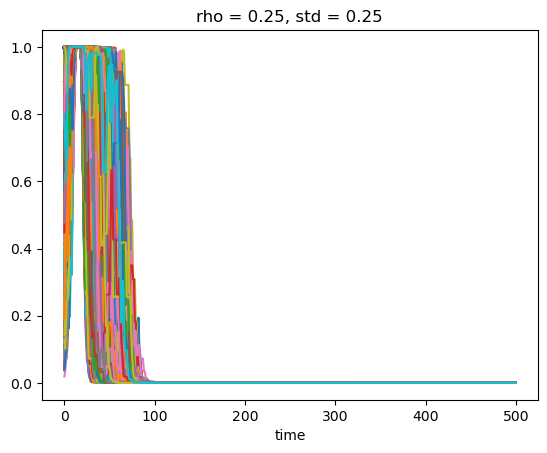

In [61]:
ks_ds.sel(rho=0.25, std=0.25).plot(hue='iteration', add_legend=False);

In [168]:
reload(toe_calc_variations)

<module 'toe_calc_variations' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py'>

In [ ]:
fga_ds = toe_calc_variations.fga(
    trend_bs_xr, trend_bs_xr.isel(time=slice(0, base_period_length)), data_ds_window).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py:21: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  base_period_kde = xr.apply_ufunc(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.96 MiB.
This may cause some slowd

In [271]:
fga_ds

<xarray.DataArray 'frac' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
79.86 81.63 84.91 85.17 84.08 ... 0.0001174 0.0001168 0.00011 9.533e-05
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
Attributes:
    bw_method:   0.2
    bmin:        -4.771673294853738
    bmax:        8.84017728850035
    num_points:  1000

### S/N Ratio

In [89]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, base_period_length)).mean(dim='time')

In [90]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [91]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, base_period_length)).std(dim='time')

In [92]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 801.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


 - full garbage collection released 109.46 MiB from 2893073 reference cycles (threshold: 9.54 MiB)


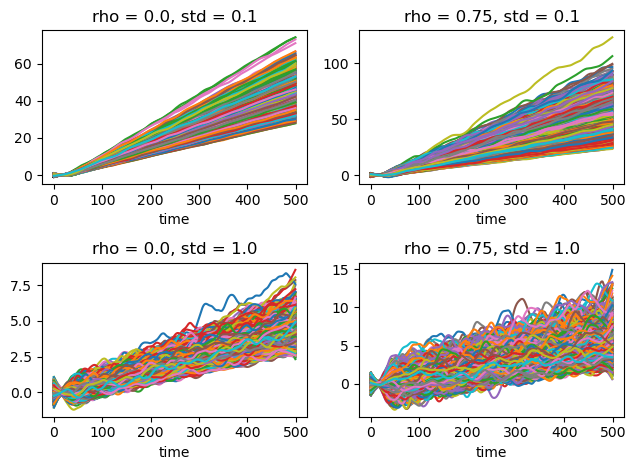

In [93]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

sn_bs_xr.sel(std=0.1, rho=0).plot(ax=axes[0], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=0.1, rho=0.75).plot(ax=axes[1], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=1, rho=0).plot(ax=axes[2], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=1, rho=0.75).plot(ax=axes[3], hue='iteration', add_legend=False);

plt.tight_layout()

### ToE

In [94]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [95]:
ks_toe_bs_xr = toe_calc.get_permanent_exceedance(
            ks_ds, threshold=0.01, comparison_func=np.less, time=sn_bs_xr.time.values)

In [96]:
fga_toe_bs_xr = toe_calc.get_permanent_exceedance(
            fga_ds, threshold=62, comparison_func=np.less, time=sn_bs_xr.time.values)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 801.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


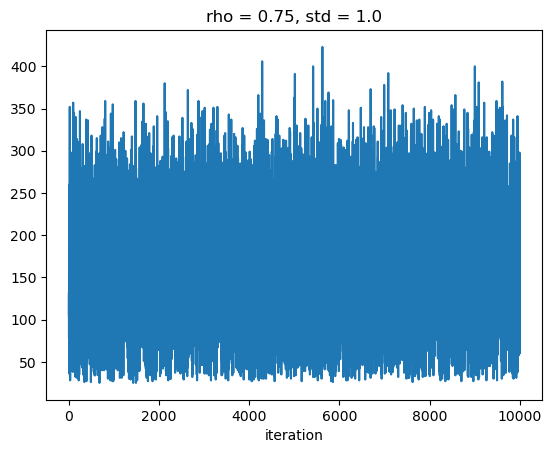

In [97]:
sn_toe_bs_xr.sel(std=1, rho=0.75).plot()

In [101]:
%%time
sn_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    sn_toe_bs_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 1.49 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 4.01 s, sys: 2.31 s, total: 6.32 s
Wall time: 8.27 s


In [102]:
%%time
ks_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    ks_toe_bs_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 5.28 s, sys: 331 ms, total: 5.61 s
Wall time: 3.85 s


In [103]:
%%time
fga_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    fga_toe_bs_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 5.26 s, sys: 283 ms, total: 5.55 s
Wall time: 3.82 s


In [104]:
ks_toe_bs_kde_xr['x'] = x
sn_toe_bs_kde_xr['x'] = x
fga_toe_bs_kde_xr['x'] = x

In [105]:
sn_toe_bs_xr = sn_toe_bs_xr.compute()
ks_toe_bs_xr = ks_toe_bs_xr.compute()
fga_toe_bs_xr = fga_toe_bs_xr.compute()

<h2 style='color:yellow'> Plotting </h2>

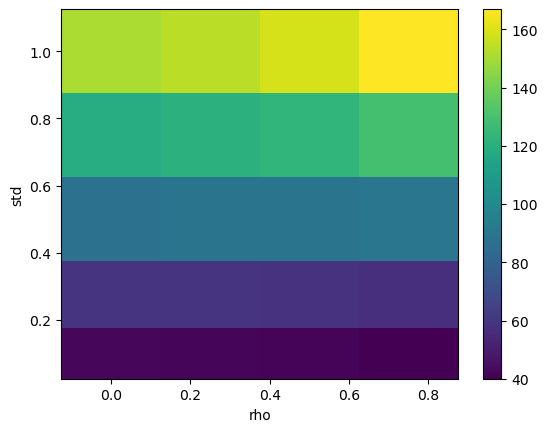

In [106]:
sn_toe_bs_xr.median(dim='iteration').plot()

In [107]:
from matplotlib.ticker import MaxNLocator

In [108]:
def plot_toe_bs_kde(toe_bs_kde_xr, toe_bs_xr, colors=None, fig=None, axs=None,
                    add_legend=True, ylabel=True):
    """
    Plots Time of Emergence (ToE) bootstrapped KDE distributions for different std values, with vertical median lines.
    
    Parameters:
    - toe_bs_kde_xr: xarray.Dataset containing KDE distributions for ToE
    - toe_bs_xr: xarray.Dataset containing raw ToE values for computing medians
    - x: numpy array of x-axis values
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    # Get unique values for rho and std
    rho_values = toe_bs_kde_xr['rho'].values
    std_values = toe_bs_kde_xr['std'].values
    x = toe_bs_kde_xr.x.values
    
    # Assign a unique color to each rho for consistency across plots
    if colors is None: colors = plt.cm.viridis(np.linspace(0, 1, len(rho_values)))
    
    # Create figure and gridspec if not provided
    if fig is None or axs is None:
        fig = plt.figure(figsize=(6, len(std_values) * 1.5))
        gs = gridspec.GridSpec(len(std_values), 1, figure=fig, hspace=0)
        axs = [fig.add_subplot(gs[i, 0]) for i in range(len(std_values))]
    
    # Loop through std (rows)
    for i, (ax, std) in enumerate(zip(axs, std_values)):
        # Plot all rho values on the same subplot, using consistent colors
        for color, rho in zip(colors, rho_values):
            data = toe_bs_kde_xr.sel(std=std, rho=rho)
            ax.plot(x, data, color=color, label=f'{rho:.2f}')
            
            # Compute and plot the median vertical line
            median_x = np.nanmedian(toe_bs_xr.sel(std=std, rho=rho).values)
            median_y = data.values[np.argmin(np.abs(x - median_x))]
            ax.plot([median_x, median_x], [0, median_y], linestyle="dashed", color=color, alpha=0.7)

        
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, min_n_ticks=4, prune=None))
        ax.set_xlim(0, 350)
        if i == 0 and add_legend: 
            leg = ax.legend(loc='upper right', fontsize=10, frameon=False)
            leg.set_title('Rho')
        if 0 < i < len(std_values) - 1:
            # ax.spines['bottom'].set_visible(False)
            ax.set_xticklabels([])
        if i == len(std_values) - 1:
            ax.set_xlabel('Time of Emergence (ToE)') 
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
        if ylabel: ax.set_ylabel(fr'$\sigma={std}$', fontsize=12)  
        ax.grid(True, linestyle='--', alpha=0.25, color='grey')
    
    return fig, axs


In [109]:
colors = plt.cm.viridis_r(np.linspace(0, 1, sn_toe_bs_kde_xr['rho'].values.shape[0]))

In [110]:
from toe_plots import METRIC_MAP

Text(0.5, 1.0, 'Fractional Geometric Area')

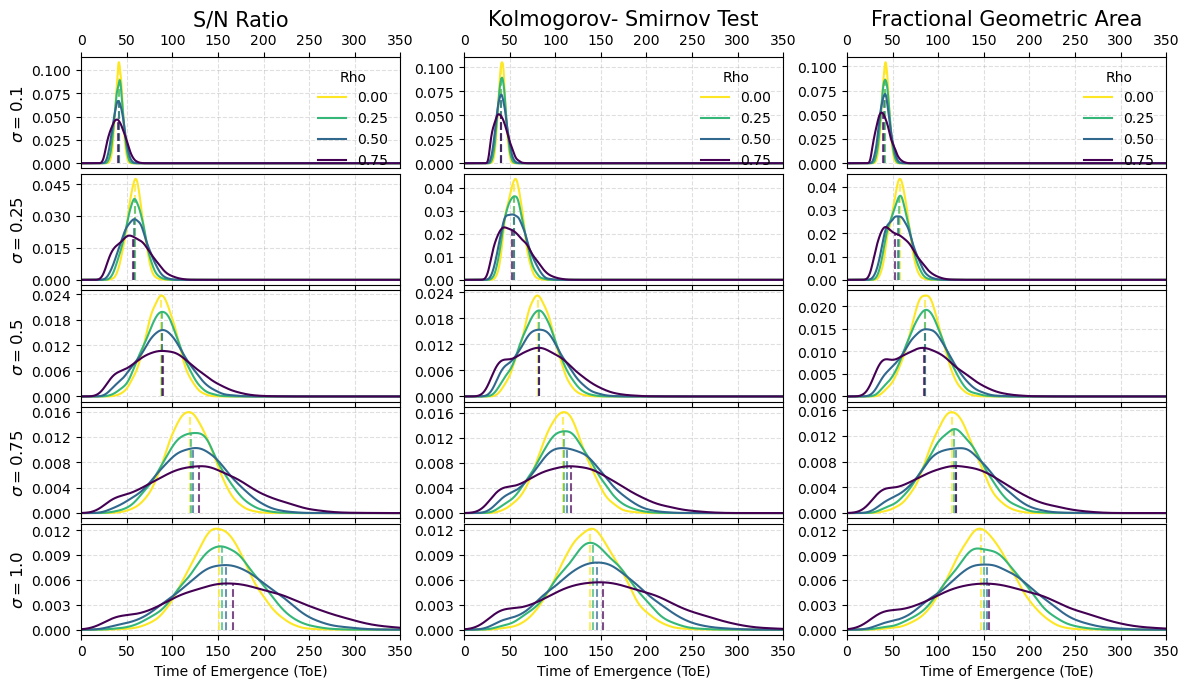

In [111]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(14, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 3, figure=fig, hspace=0.05)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_middle = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 2]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_middle, colors=colors, ylabel=False);
plot_toe_bs_kde(fga_toe_bs_kde_xr, fga_toe_bs_xr, fig=fig, axs=axes_right, colors=colors, ylabel=False);


axes_left[0].set_title(METRIC_MAP['sn'], fontsize=15)
axes_middle[0].set_title(METRIC_MAP['ks'].replace('\n', ' '), fontsize=15)
axes_right[0].set_title(METRIC_MAP['frac'].replace('\n', ' '), fontsize=15)

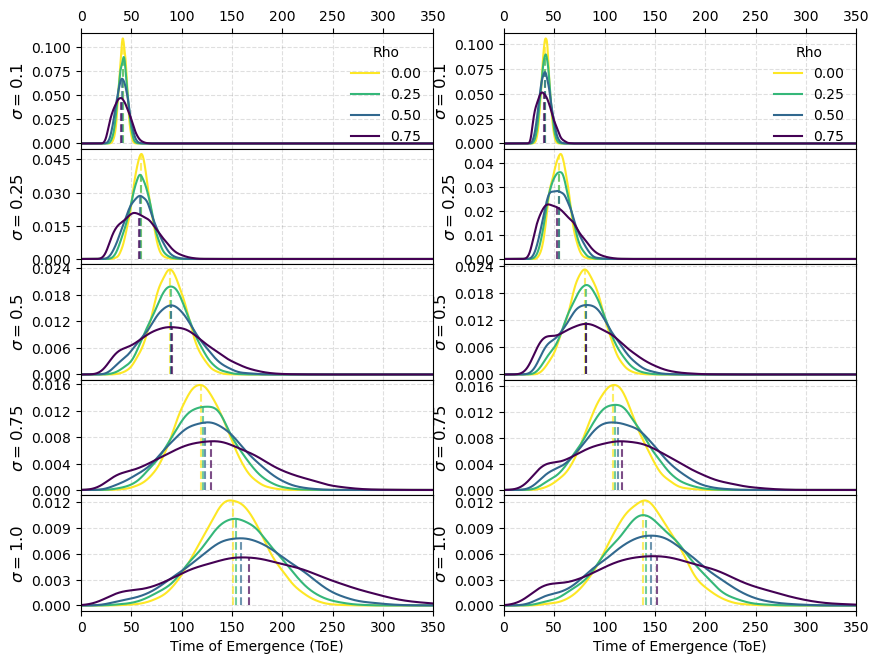

In [112]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(10, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 2, figure=fig, hspace=0)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_right, colors=colors);

<h1 style='color:cyan'> Non-stationary Variance </h1>

<h2 style='color:yellow'> Generating Data </h2>

In [28]:
reload(toe_calc_variations)

<module 'toe_calc_variations' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py'>

In [29]:
true_trend.shape

(500,)

In [30]:
base_noise_xr = generate_noise_ensemble(
            1, 0, length=true_trend.shape[0],
            rtol=0.2, num_trials=10000)


std=1 - rho=0 - length=500 - atol=0.2

1 (0), 2 (100), 3 (200), 4 (300), 5 (400), 6 (500), 7 (600), 8 (700), 9 (800), 10 (900), 11 (1000), 12 (1100), 13 (1200), 14 (1300), 15 (1400), 16 (1500), 17 (1600), 18 (1700), 19 (1800), 20 (1900), 21 (2000), 22 (2100), 23 (2200), 24 (2300), 25 (2400), 26 (2500), 27 (2600), 28 (2700), 29 (2800), 30 (2900), 31 (3000), 32 (3100), 33 (3200), 34 (3300), 35 (3400), 36 (3500), 37 (3600), 38 (3700), 39 (3800), 40 (3900), 41 (4000), 42 (4100), 43 (4200), 44 (4300), 45 (4400), 46 (4500), 47 (4600), 48 (4700), 49 (4800), 50 (4900), 51 (5000), 52 (5100), 53 (5200), 54 (5300), 55 (5400), 56 (5500), 57 (5600), 58 (5700), 59 (5800), 60 (5900), 61 (6000), 62 (6100), 63 (6200), 64 (6300), 65 (6400), 66 (6500), 67 (6600), 68 (6700), 69 (6800), 70 (6900), 71 (7000), 72 (7100), 73 (7200), 74 (7300), 75 (7400), 76 (7500), 77 (7600), 78 (7700), 79 (7800), 80 (7900), 81 (8000), 82 (8100), 83 (8200), 84 (8300), 85 (8400), 86 (8500), 87 (8600), 88 (8700), 89 (8800), 90

In [31]:
non_stationary_noise

<function __main__.non_stationary_noise(arr: numpy.ndarray, start_std: float, end_std: float, window: int) -> numpy.ndarray>

In [32]:
non_stat_noise_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    vectorize=True,
    dask = 'parallelized',
    output_dtypes=[float]
)

In [33]:
base_noise_0p1t1p0_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.1, end_std=1, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p1t1p0_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [34]:
base_noise_0p1t0p5_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.1, end_std=0.5, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p1t0p5_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [35]:
base_noise_0p5t1p0_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.5, end_std=1, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p5t1p0_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [36]:
def revers_time_values(ds):
    ds2 = ds.copy(deep=True)
    ds2.data = ds2.data[..., ::-1]
    return ds2

In [37]:
# Reverse nosie for trends with decreasing noise
base_noise_1p0t0p1_xr = revers_time_values(base_noise_0p1t1p0_xr)
base_noise_1p0t0p5_xr = revers_time_values(base_noise_0p5t1p0_xr)
base_noise_0p5t0p1_xr = revers_time_values(base_noise_0p1t0p5_xr)

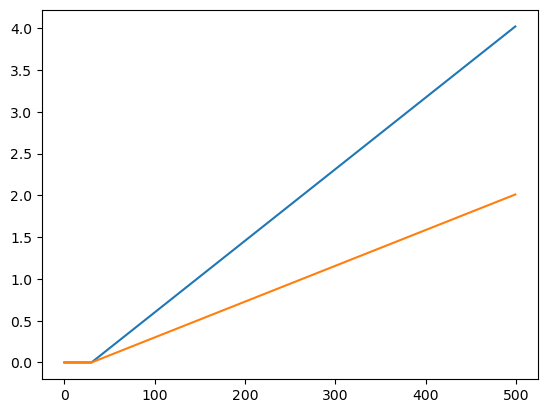

In [38]:
plt.plot(true_trend)
plt.plot(true_trend/2)

In [39]:
# Increading trends
# Divide true trend by 2 as ToE is too early
trend_0p1t1p0_xr = base_noise_0p1t1p0_xr + true_trend/2
trend_0p5t1p0_xr = base_noise_0p5t1p0_xr + true_trend/2
trend_0p1t0p5_xr = base_noise_0p1t0p5_xr + true_trend/2

In [40]:
# Decrsing trends
trend_1p0t0p1_xr = base_noise_1p0t0p1_xr + true_trend
trend_1p0t0p5_xr = base_noise_1p0t0p5_xr + true_trend
trend_0p5t0p1_xr = base_noise_0p5t0p1_xr + true_trend

In [41]:
trend_0p1t1p0_xr['std'] = '0p1t1p0'
trend_0p5t1p0_xr['std'] = '0p5t1p0'
trend_0p1t0p5_xr['std'] = '0p1t0p5'
trend_1p0t0p1_xr['std'] = '1p0t0p1'
trend_1p0t0p5_xr['std'] = '1p0t0p5'
trend_0p5t0p1_xr['std'] = '0p5t0p1'

In [42]:
trend_non_stat_xr = xr.concat(
    [trend_0p1t1p0_xr, trend_0p5t1p0_xr, trend_0p1t0p5_xr,
     trend_1p0t0p1_xr, trend_1p0t0p5_xr, trend_0p5t0p1_xr], dim='std')

In [43]:
trend_non_stat_xr

<xarray.DataArray (std: 6, iteration: 10000, time: 500)> Size: 240MB
dask.array<chunksize=(1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    rho        int64 8B 0
  * std        (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'

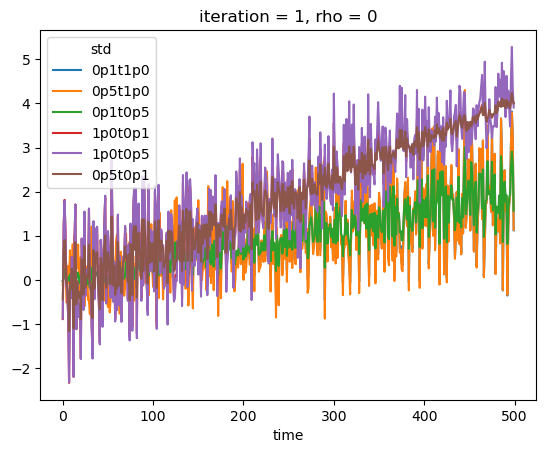

In [44]:
trend_non_stat_xr.isel(iteration=1).plot(hue='std');

<h2 style='color:yellow'> ToE Calculation </h2>

In [114]:
data_ds_window_non_stat = (trend_non_stat_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds_non_stat = (trend_non_stat_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window_non_stat);
wait(base_period_window_ds_non_stat);

In [115]:
ks_non_stat_ds = toe_calc_variations.ks(data_ds_window_non_stat.isel(iteration=slice(0,100)),
                                        base_period_window_ds_non_stat.isel(iteration=slice(0,100)))

In [216]:
trend_non_stat_xr

<xarray.DataArray (std: 6, iteration: 10000, time: 500)> Size: 240MB
dask.array<concatenate, shape=(6, 10000, 500), dtype=float64, chunksize=(1, 10000, 500), chunktype=numpy.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    rho        int64 8B 0
  * std        (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'

In [199]:
fga_non_stat_ds = toe_calc_variations.fga(
    trend_non_stat_xr,#.isel(iteration=slice(0,100)),
    trend_non_stat_xr.isel(time=slice(0, base_period_length)),#.isel(iteration=slice(0,100)),
    data_ds_window_non_stat#.isel(iteration=slice(0,100))
).compute()

In [200]:
reload(toe_calc_variations)

<module 'toe_calc_variations' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py'>

In [201]:
sn_non_stat_xr = toe_calc_variations.sn_ratio(
    trend_non_stat_xr,#.isel(iteration=slice(0,100)),
    start=0, end=30)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 228.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


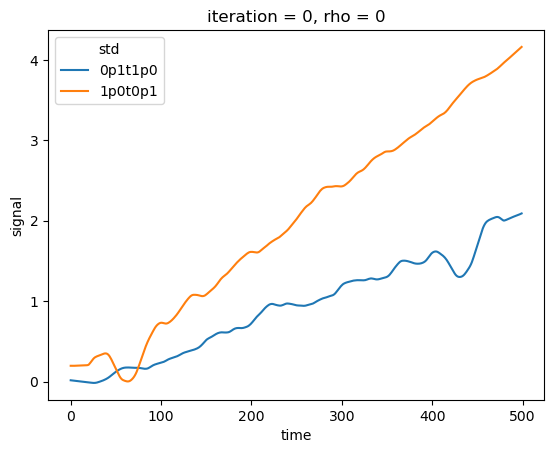

In [202]:
sn_non_stat_xr.signal.sel(std=['0p1t1p0', '1p0t0p1']).isel(iteration=0).plot(hue='std');

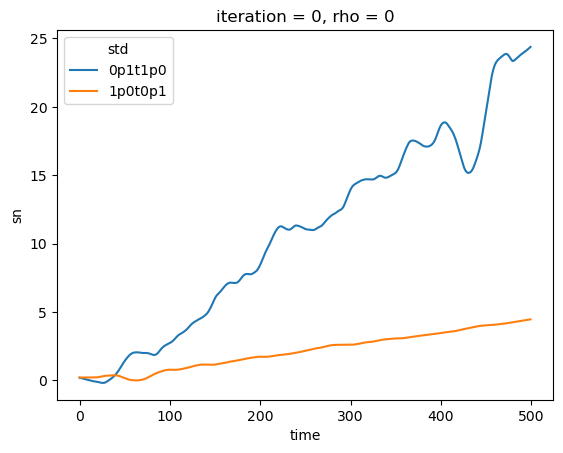

In [203]:
sn_non_stat_xr.sn.sel(std=['0p1t1p0', '1p0t0p1']).isel(iteration=0).plot(hue='std');

In [204]:
ks_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            ks_non_stat_ds, threshold=0.01, comparison_func=np.less, time=ks_non_stat_ds.time.values).compute()

In [205]:
sn_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            sn_non_stat_xr[['sn', 'sn_lowess_full', 'sn_roll']],
    threshold=1, comparison_func=np.greater, time=sn_non_stat_xr.time.values, trim_nan=True).compute()

In [206]:
fga_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            fga_non_stat_ds, threshold=62, comparison_func=np.less, time=fga_non_stat_ds.time.values).compute()

In [207]:
%%time
ks_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    ks_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

CPU times: user 21.2 ms, sys: 7.88 ms, total: 29.1 ms
Wall time: 15.7 ms


<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


In [208]:
%%time
sn_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    sn_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 4.73 s, sys: 332 ms, total: 5.06 s
Wall time: 3.31 s


In [209]:
%%time
fga_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    fga_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 1.58 s, sys: 117 ms, total: 1.7 s
Wall time: 1.12 s


In [210]:
ks_toe_non_stat_kde_xr['x'] = x
fga_toe_non_stat_kde_xr['x'] = x
sn_toe_non_stat_kde_xr['x'] = x

<h2 style='color:yellow'> Plots </h2>

In [267]:
def plot_toe_bs_kde_custom(kde_xr, toe_xr, colors=None, fig=None, axs=None, add_legend=True):
    """
    Plots Time of Emergence (ToE) KDE distributions for different datasets (KS and FGA) as variables within a merged dataset,
    with distinct colors for each dataset and different std values with distinct linestyles.

    Parameters:
    - kde_xr: xarray.Dataset containing KDE distributions with 'KS' and 'FGA' as variables
    - std_values: List of std values to plot
    - colors: Optional color list for datasets
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    x = kde_xr.x.values  # Assuming all datasets share the same x values
    std_values = kde_xr['std'].values
    toe_metrics = list(kde_xr)
    
    nrows = int(np.ceil(len(std_values)/2))
    # Create figure and gridspec if not provided
    if fig is None or axs is None:
        fig = plt.figure(figsize=(5*nrows, 10))
        gs = gridspec.GridSpec(nrows, 2, figure=fig, hspace=0.1)
        axs = []
        for j in range(2):  # Since you have 2 columns
            for i in range(nrows):
                axs.append(fig.add_subplot(gs[i, j]))
        # axs = [fig.add_subplot(gs[i]) for i in range(len(std_values))]
    
    for i, std in enumerate(std_values):
        ax = axs[i]
        for toe_met in toe_metrics:
            style = toe_plots.TEST_STYLES.get(toe_met, {'color':'black', 'linestyle':'sold'})
            data = kde_xr[toe_met].sel(std=std)

            ax.plot(x, data, label=toe_plots.METRIC_MAP.get(toe_met, toe_met).replace('\n', ' ').replace(' (', '\n('), **style)
            median_x = np.nanmedian(toe_xr[toe_met].sel(std=std).values)
            median_y = data.values[np.argmin(np.abs(x - median_x))]
            # ax.plot([median_x, median_x], [0, median_y], **style)
    
        ax.set_xlim(0, 350)
        if i in [0, 3]:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
        elif i in [2, 5]:
            ax.set_xlabel("Time of Emergence (ToE)", fontsize=15)

        if i in [1, 4]:
            ax.set_xticklabels([])
        else:
            ax.tick_params(axis='x', labelsize=12)
    
        
        ax.grid(True, linestyle="--", alpha=0.25, color="grey")
        ax.set_ylabel(r'$\sigma=$' + std.replace('p', '.').replace('t', ' to '), fontsize=15)
    
    if add_legend:
        axs[0].legend(loc='upper right', fontsize=12, frameon=False)#, bbox_to_anchor=(1.5, 0.5))

    axs[0].set_title('Increasing Variability', fontsize=15)
    axs[3].set_title('Decreasing Variability', fontsize=15)

In [268]:
toe_non_stat_kde_xr = xr.merge([sn_toe_non_stat_kde_xr, ks_toe_non_stat_kde_xr, fga_toe_non_stat_kde_xr])

In [269]:
toe_non_stat_xr = xr.merge([sn_toe_non_stat_xr, ks_toe_non_stat_xr, fga_toe_non_stat_xr])

In [270]:
non_stat_tests = list(toe_non_stat_kde_xr)
non_stat_tests

['sn', 'sn_lowess_full', 'sn_roll', 'ks', 'frac']

In [271]:
std_order = ['0p1t0p5', '0p5t1p0', '0p1t1p0', '0p5t0p1', '1p0t0p5', '1p0t0p1']

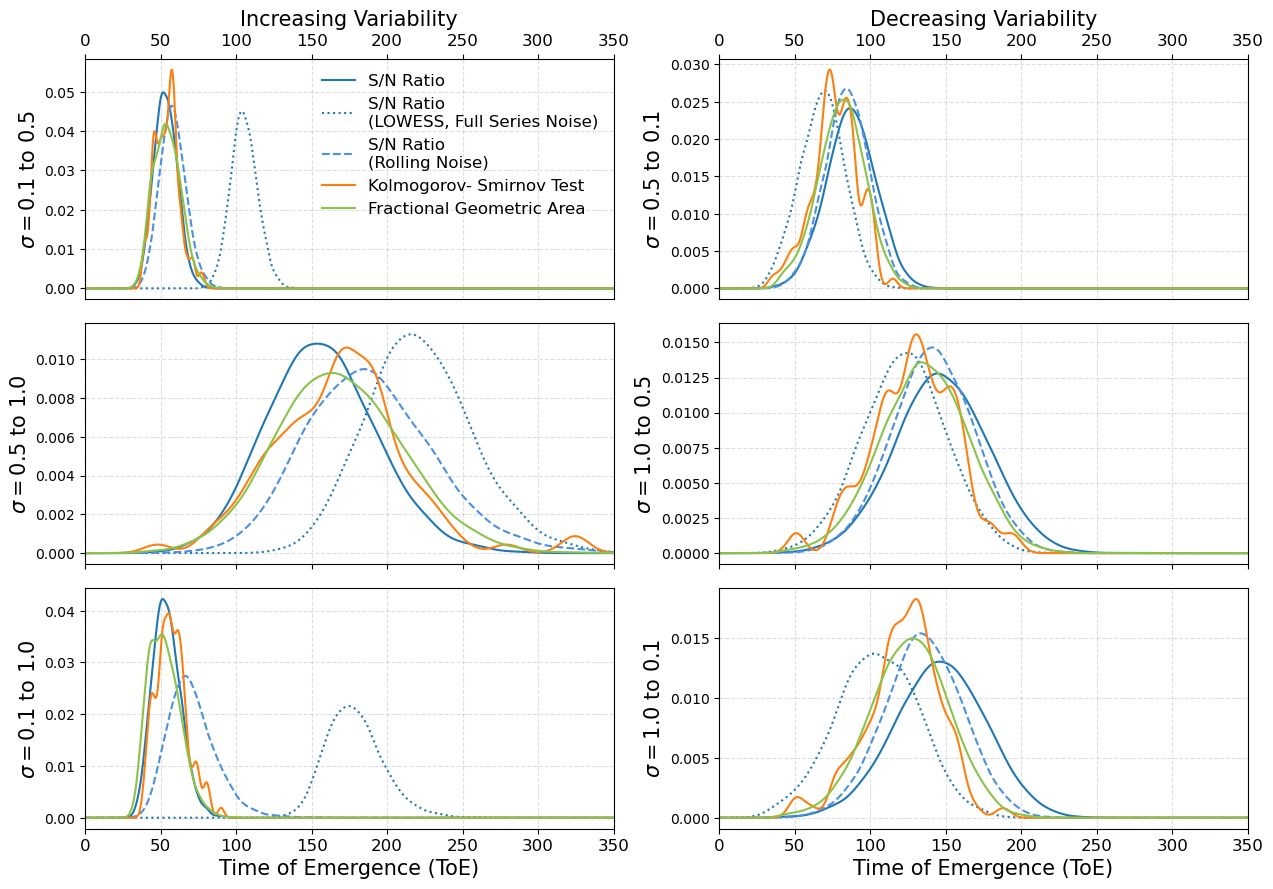

In [272]:
plot_toe_bs_kde_custom(toe_non_stat_kde_xr.sel(std=std_order), toe_non_stat_xr)#['sn', 'sn_lowess_full', 'ks', 'frac']]);

<h1 style='color:yellow'> Trend Demonstartion </h1>

In [45]:
colors = plt.cm.viridis_r(np.linspace(0, 1, trend_bs_xr['rho'].values.shape[0]))

In [46]:
trend_bs_xr_sample = trend_bs_xr.isel(iteration=0).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [47]:
 trend_non_stat_xr.isel(iteration=0).values

array([[-0.09755302,  0.11914534, -0.05195872, ...,  3.24370927,
         1.90763097,  0.97087221],
       [-0.66248695,  0.78964628, -0.33630193, ...,  3.23030276,
         1.90876895,  0.98376728],
       [-0.11939325,  0.14338529, -0.06152226, ...,  2.62089311,
         1.95681488,  1.49204799],
       [-1.03912779, -0.09808332,  1.2422807 , ...,  3.95089843,
         4.13057391,  3.92244698],
       [-1.02623272, -0.09694533,  1.22887418, ...,  3.66655522,
         4.80107486,  3.35751305],
       [-0.51795201, -0.04889941,  0.61946453, ...,  3.94133488,
         4.15481386,  3.90060675]])

In [48]:
trend_non_stat_xr_sample = trend_non_stat_xr.isel(iteration=0).compute()

In [64]:
non_stat_std_values

array(['0p1t1p0', '0p5t1p0', '0p1t0p5', '1p0t0p1', '1p0t0p5', '0p5t0p1'],
      dtype='<U7')

In [85]:
grad_label = grad * 10
grad_label2 = grad_label/2

Text(0.5, 1.0, 'Decreasing Variance')

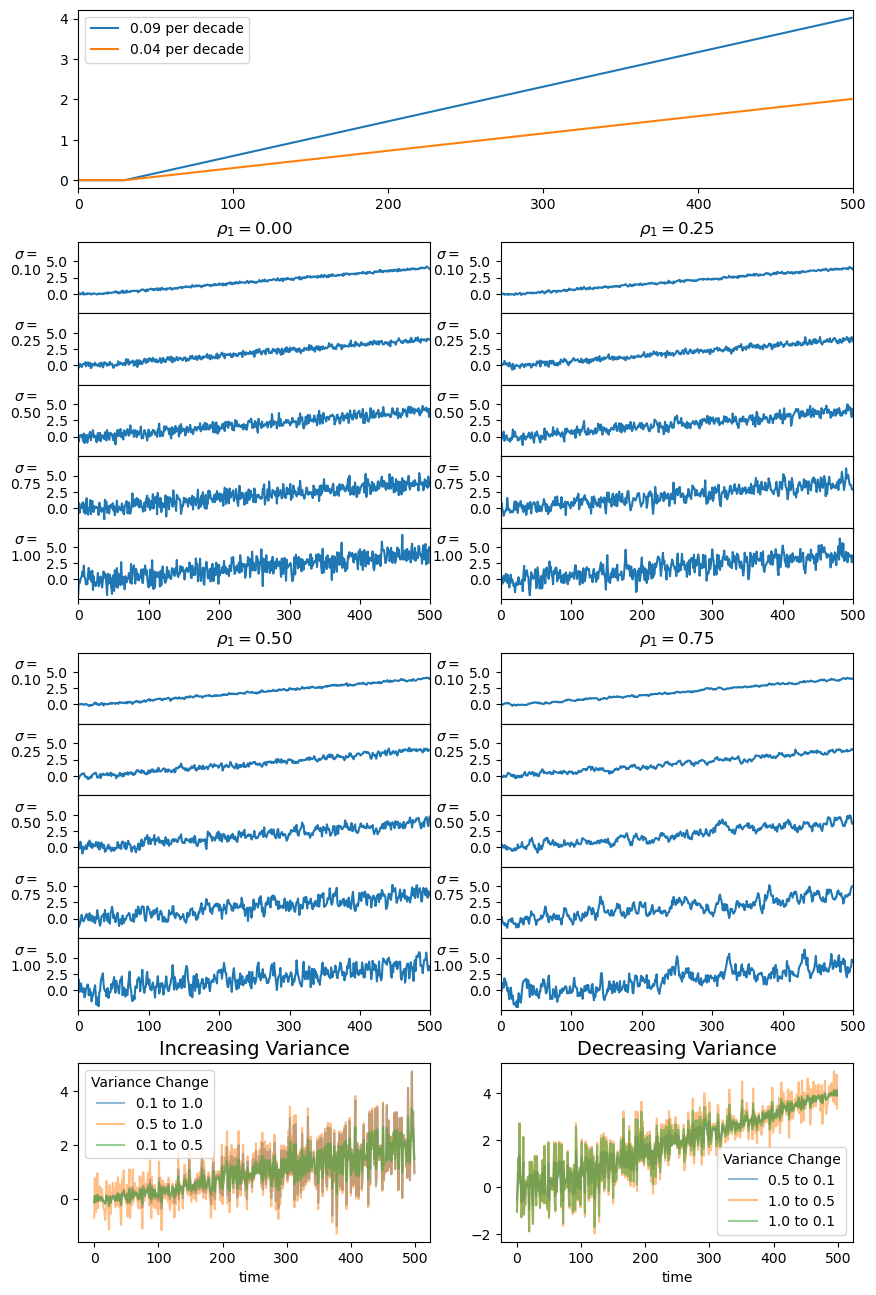

In [88]:
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4,2, hspace=0.2, height_ratios=[0.5, 1, 1, 0.5])
ax_top = fig.add_subplot(gs[0, :])

ax_top.plot(true_trend, label=f'{grad_label:.2f} per decade')
ax_top.plot(true_trend/2, label=f'{grad_label2:.2f} per decade')
ax_top.set_xlim(0, 500)
ax_top.legend()

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    rho_gs = gridspec.GridSpecFromSubplotSpec(len(std_values), 1, hspace=0, subplot_spec=gs[2+num])
    rho_axes = [fig.add_subplot(rho_gs[i]) for i in range(len(std_values))]
    for num2, std in enumerate(std_values):
        ax = rho_axes[num2]
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values)
        ax.set_ylabel(r'$\sigma=$'+f'\n{std:0.2f}', rotation=0, labelpad=15)
        ax.set_yticks([0, 2.5, 5])
        ax.set_ylim(-3, 8)
        ax.set_xlim(0, 500)
        if num2 < (len(std_values)-1):
            ax.set_xticklabels([])
        
    rho_axes[0].set_title(r'$\rho_1=$'+f'{rho:0.2f}')


non_stat_ax1 = fig.add_subplot(gs[-2])
non_stat_ax2 = fig.add_subplot(gs[-1])


non_stat_std_values = trend_non_stat_xr_sample['std'].values
for i in range(3):
    std_vali  = non_stat_std_values[i]
    std_valim  = non_stat_std_values[-i-1]

    trend_non_stat_xr_sample.sel(std=std_vali).plot(ax=non_stat_ax1, alpha=0.5,
                                                    label=std_vali.replace('p', '.').replace('t', ' to '))
    trend_non_stat_xr_sample.sel(std=std_valim).plot(ax=non_stat_ax2, alpha=0.5,
                                                    label=std_valim.replace('p', '.').replace('t', ' to '))

leg1 = non_stat_ax1.legend()
leg1.set_title('Variance Change')

leg2 = non_stat_ax2.legend()
leg2.set_title('Variance Change')
non_stat_ax1.set_title('Increasing Variance', fontsize=14)
non_stat_ax2.set_title('Decreasing Variance', fontsize=14)

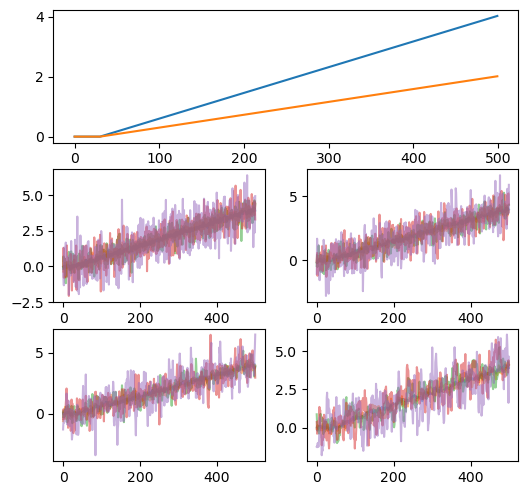

In [296]:
fig = plt.figure(figsize=(6, 10))
gs = gridspec.GridSpec(5,2)

ax_top = fig.add_subplot(gs[0, :])
rho_axes = np.array([fig.add_subplot(gs[row, col]) for row, col in [(1, 0), (1,1), (2, 0), (2, 1)]]).ravel()

ax_top.plot(true_trend)
ax_top.plot(true_trend/2)

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    ax = rho_axes[num]
    for std in std_values:
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values, alpha=0.5)

In [273]:
trend_non_stat_xr

<xarray.DataArray (std: 6, iteration: 10000, time: 500)> Size: 240MB
dask.array<concatenate, shape=(6, 10000, 500), dtype=float64, chunksize=(1, 10000, 500), chunktype=numpy.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    rho        int64 8B 0
  * std        (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'

In [274]:
trend_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<add, shape=(5, 4, 10000, 500), dtype=float64, chunksize=(1, 1, 10000, 500), chunktype=numpy.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

# Old 

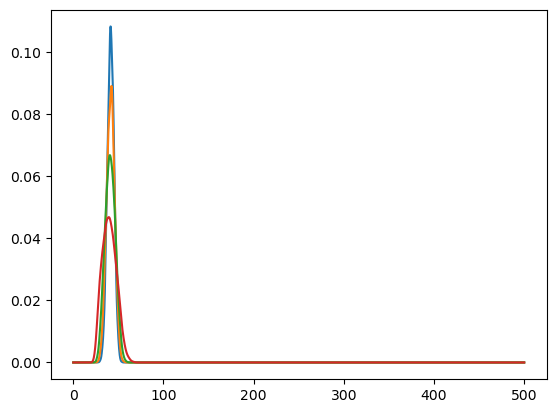

In [113]:
for rho in sn_toe_bs_kde_xr['rho'].values:
    plt.plot(x, sn_toe_bs_kde_xr.sel(std=0.1, rho=rho))

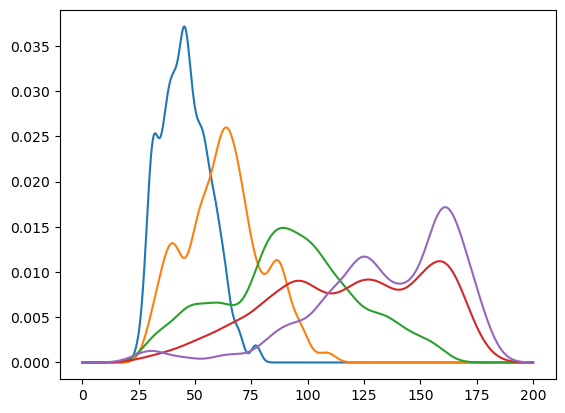

In [227]:
for std in sn_toe_bs_kde_xr['std'].values:
    plt.plot(x, sn_toe_bs_kde_xr.sel(std=std, rho=0.75))

In [219]:
sn_toe_bs_kde_xr

<xarray.DataArray (std: 5, rho: 4, x: 1000)> Size: 160kB
0.0 0.0 0.0 0.0 0.0 0.0 ... 1.031e-05 9.303e-06 8.388e-06 7.556e-06 6.801e-06
Coordinates:
  * rho      (rho) float64 32B 0.0 0.25 0.5 0.75
  * std      (std) float64 40B 0.1 0.25 0.5 0.75 1.0
Dimensions without coordinates: x

In [212]:
sn_toe_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 200)> Size: 32kB
44.0 45.0 42.0 40.0 41.0 46.0 41.0 40.0 ... 157.0 146.0 nan nan nan 165.0 159.0
Coordinates:
  * iteration  (iteration) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

In [ ]:

sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)

In [136]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [137]:
toe_median_1

<xarray.DataArray (multiplier: 4)> Size: 32B
array([ 60.,  90., 118., 145.])
Coordinates:
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [138]:
# toe_median_1#.isel(multiplier=0)

In [139]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [140]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [141]:
ratio_s_std_to_noise_std

<xarray.DataArray (multiplier: 4)> Size: 32B
array([2.391624  , 2.49881627, 2.53490038, 2.5957802 ])
Coordinates:
    time        (multiplier) int64 32B 60 90 118 145
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [142]:
x = np.linspace(0, 200, 1000)

In [143]:
sn_toe_bs_xr

<xarray.DataArray (multiplier: 4, iteration: 200)> Size: 6kB
array([[ 49.,  60.,  70.,  54.,  57.,  50.,  59.,  63.,  52.,  60.,  51.,
         59.,  55.,  56.,  70.,  61.,  63.,  61.,  60.,  73.,  44.,  65.,
         64.,  68.,  48.,  62.,  71.,  78.,  64.,  52.,  50.,  75.,  49.,
         64.,  54.,  56.,  66.,  80.,  51.,  59.,  78.,  69.,  71.,  47.,
         72.,  65.,  60.,  56.,  75.,  57.,  44.,  61.,  67.,  76.,  47.,
         58.,  50.,  64.,  57.,  53.,  61.,  57.,  53.,  60.,  57.,  66.,
         54.,  52.,  71.,  52.,  77.,  78.,  52.,  78.,  54.,  64.,  62.,
         74.,  72.,  54.,  57.,  57.,  51.,  52.,  44.,  55.,  57.,  84.,
         50.,  59.,  56.,  55.,  58.,  69.,  76.,  34.,  57.,  67.,  61.,
         72.,  56.,  42.,  51.,  62.,  60.,  59.,  52.,  62.,  64.,  59.,
         53.,  55.,  72.,  58.,  57.,  41.,  35.,  63.,  61.,  56.,  63.,
         50.,  73.,  62.,  88.,  66.,  46.,  68.,  64.,  43.,  83.,  55.,
         50.,  74.,  57.,  70.,  76.,  66.,  68.,  78.,  44.,  46.,  58.,
         66.,  62.,  54.,  70.,  57.,  65.,  62.,  67.,  72.,  53.,  63.,
         59.,  72.,  62.,  63.,  61.,  81.,  75.,  77.,  54.,  56.,  70.,
         53.,  66.,  65.,  47.,  59.,  75.,  66.,  34.,  60.,  57.,  71.,
         62.,  49.,  72.,  52.,  38.,  79.,  51.,  62.,  59.,  51.,  66.,
         55.,  69.,  57.,  70.,  60.,  45.,  68.,  54.,  65.,  64.,  77.,
         58.,  64.],
       [ 83.,  94., 106.,  70.,  72.,  61.,  89.,  75.,  60.,  95.,  64.,
...
         84., 127.],
       [115., 104., 174.,  nan,  nan,  nan,  nan, 141.,  67., 132., 159.,
        165., 127.,  nan, 155., 138.,  nan, 136., 148.,  nan, 128., 122.,
         nan, 158., 137., 157., 117.,  nan, 170.,  nan,  nan, 171., 127.,
         nan, 116., 117.,  nan,  nan, 123.,  nan, 168.,  nan, 175., 136.,
        167., 134., 163., 151.,  nan,  nan, 120.,  nan,  nan,  nan,  58.,
         nan, 165., 138., 157., 143., 170., 126., 149., 156., 136., 155.,
        154.,  nan, 142., 169., 153.,  nan, 121.,  nan,  nan, 169., 175.,
         nan,  nan, 156.,  nan, 166.,  70., 133., 121., 157., 117.,  nan,
         nan, 139.,  nan, 139.,  nan,  nan, 175.,  75., 139.,  nan, 166.,
        171., 137., 104., 166., 141., 165., 149., 103.,  nan, 176.,  nan,
        145., 125.,  nan, 103.,  nan, 130.,  86., 178.,  nan,  nan,  nan,
         nan, 154., 134.,  nan, 162., 142., 161., 148., 127., 163., 152.,
        115.,  nan, 154., 137.,  nan, 146., 156.,  nan, 109.,  92., 110.,
        151.,  nan, 123., 159., 136., 149.,  93., 146.,  nan,  nan, 137.,
        162., 117., 147., 160.,  nan, 159., 148., 173., 157.,  nan,  nan,
         nan, 130., 137., 131., 140.,  nan, 164., 108.,  nan, 156.,  nan,
        158., 155., 161., 134.,  71., 144.,  nan, 171., 116., 170.,  nan,
        138., 167., 140., 126., 155.,  nan, 148.,  nan, 167.,  nan,  nan,
        121., 158.]])
Coordinates:
  * iteration   (iteration) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [144]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

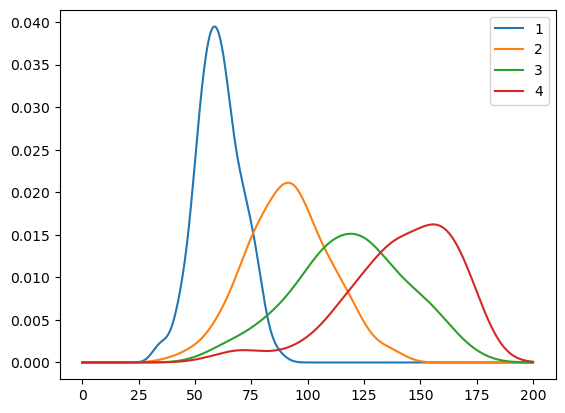

In [145]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [131]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, 30)).mean(dim='time')

In [132]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [133]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, 30)).std(dim='time')

In [134]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

In [135]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [136]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [137]:
toe_median_1

<xarray.DataArray (multiplier: 4)> Size: 32B
array([ 60.,  90., 118., 145.])
Coordinates:
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [138]:
# toe_median_1#.isel(multiplier=0)

In [139]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [140]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [141]:
ratio_s_std_to_noise_std

<xarray.DataArray (multiplier: 4)> Size: 32B
array([2.391624  , 2.49881627, 2.53490038, 2.5957802 ])
Coordinates:
    time        (multiplier) int64 32B 60 90 118 145
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [142]:
x = np.linspace(0, 200, 1000)

In [143]:
sn_toe_bs_xr

<xarray.DataArray (multiplier: 4, iteration: 200)> Size: 6kB
array([[ 49.,  60.,  70.,  54.,  57.,  50.,  59.,  63.,  52.,  60.,  51.,
         59.,  55.,  56.,  70.,  61.,  63.,  61.,  60.,  73.,  44.,  65.,
         64.,  68.,  48.,  62.,  71.,  78.,  64.,  52.,  50.,  75.,  49.,
         64.,  54.,  56.,  66.,  80.,  51.,  59.,  78.,  69.,  71.,  47.,
         72.,  65.,  60.,  56.,  75.,  57.,  44.,  61.,  67.,  76.,  47.,
         58.,  50.,  64.,  57.,  53.,  61.,  57.,  53.,  60.,  57.,  66.,
         54.,  52.,  71.,  52.,  77.,  78.,  52.,  78.,  54.,  64.,  62.,
         74.,  72.,  54.,  57.,  57.,  51.,  52.,  44.,  55.,  57.,  84.,
         50.,  59.,  56.,  55.,  58.,  69.,  76.,  34.,  57.,  67.,  61.,
         72.,  56.,  42.,  51.,  62.,  60.,  59.,  52.,  62.,  64.,  59.,
         53.,  55.,  72.,  58.,  57.,  41.,  35.,  63.,  61.,  56.,  63.,
         50.,  73.,  62.,  88.,  66.,  46.,  68.,  64.,  43.,  83.,  55.,
         50.,  74.,  57.,  70.,  76.,  66.,  68.,  78.,  44.,  46.,  58.,
         66.,  62.,  54.,  70.,  57.,  65.,  62.,  67.,  72.,  53.,  63.,
         59.,  72.,  62.,  63.,  61.,  81.,  75.,  77.,  54.,  56.,  70.,
         53.,  66.,  65.,  47.,  59.,  75.,  66.,  34.,  60.,  57.,  71.,
         62.,  49.,  72.,  52.,  38.,  79.,  51.,  62.,  59.,  51.,  66.,
         55.,  69.,  57.,  70.,  60.,  45.,  68.,  54.,  65.,  64.,  77.,
         58.,  64.],
       [ 83.,  94., 106.,  70.,  72.,  61.,  89.,  75.,  60.,  95.,  64.,
...
         84., 127.],
       [115., 104., 174.,  nan,  nan,  nan,  nan, 141.,  67., 132., 159.,
        165., 127.,  nan, 155., 138.,  nan, 136., 148.,  nan, 128., 122.,
         nan, 158., 137., 157., 117.,  nan, 170.,  nan,  nan, 171., 127.,
         nan, 116., 117.,  nan,  nan, 123.,  nan, 168.,  nan, 175., 136.,
        167., 134., 163., 151.,  nan,  nan, 120.,  nan,  nan,  nan,  58.,
         nan, 165., 138., 157., 143., 170., 126., 149., 156., 136., 155.,
        154.,  nan, 142., 169., 153.,  nan, 121.,  nan,  nan, 169., 175.,
         nan,  nan, 156.,  nan, 166.,  70., 133., 121., 157., 117.,  nan,
         nan, 139.,  nan, 139.,  nan,  nan, 175.,  75., 139.,  nan, 166.,
        171., 137., 104., 166., 141., 165., 149., 103.,  nan, 176.,  nan,
        145., 125.,  nan, 103.,  nan, 130.,  86., 178.,  nan,  nan,  nan,
         nan, 154., 134.,  nan, 162., 142., 161., 148., 127., 163., 152.,
        115.,  nan, 154., 137.,  nan, 146., 156.,  nan, 109.,  92., 110.,
        151.,  nan, 123., 159., 136., 149.,  93., 146.,  nan,  nan, 137.,
        162., 117., 147., 160.,  nan, 159., 148., 173., 157.,  nan,  nan,
         nan, 130., 137., 131., 140.,  nan, 164., 108.,  nan, 156.,  nan,
        158., 155., 161., 134.,  71., 144.,  nan, 171., 116., 170.,  nan,
        138., 167., 140., 126., 155.,  nan, 148.,  nan, 167.,  nan,  nan,
        121., 158.]])
Coordinates:
  * iteration   (iteration) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [144]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

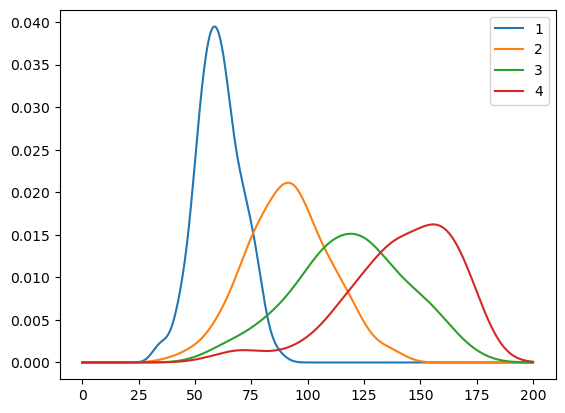

In [145]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [150]:


noise_bs_xr = generate_noise_ensemble(0.25, 0.2, length=true_trend.shape[0])

In [128]:
trend_bs_xr = noise_bs_xr + true_trend

In [130]:
multipliers = [1, 2, 3, 4]

# Stack different noise scalings into a new "multiplier" dimension
trend_bs_xr = xr.concat([true_trend + noise_bs_xr * m for m in multipliers], dim="multiplier")

# Assign correct multiplier labels
trend_bs_xr["multiplier"] = multipliers
trend_bs_xr

<xarray.DataArray (multiplier: 4, iteration: 200, time: 180)> Size: 1MB
array([[[ 0.52327895,  0.26580038,  0.09180577, ...,  1.35575117,
          1.00136627,  1.65559415],
        [ 0.35760886,  0.50649933,  0.2549926 , ...,  1.46139286,
          1.60629474,  1.51169823],
        [-0.12439611,  0.29257918,  0.17604118, ...,  1.19987561,
          1.40560667,  1.66885664],
        ...,
        [ 0.34067176,  0.05503246,  0.35933244, ...,  1.1408221 ,
          1.16822374,  1.03470991],
        [ 0.02405418,  0.36223326, -0.10308296, ...,  1.35911588,
          1.4703625 ,  1.7275847 ],
        [ 0.02452842,  0.1179446 , -0.11685737, ...,  1.78703191,
          1.46424772,  1.30979215]],

       [[ 1.0465579 ,  0.53160077,  0.18361155, ...,  1.45150233,
          0.73416111,  2.03404545],
        [ 0.71521773,  1.01299866,  0.5099852 , ...,  1.66278573,
          1.94401805,  1.7462536 ],
        [-0.24879223,  0.58515836,  0.35208237, ...,  1.13975123,
          1.54264192,  2.06057042],
...
        [ 1.02201529,  0.16509739,  1.07799732, ...,  0.90246629,
          0.96752835,  0.54984401],
        [ 0.07216254,  1.08669979, -0.30924887, ...,  1.55734764,
          1.87394463,  2.62846839],
        [ 0.07358527,  0.35383379, -0.35057212, ...,  2.84109573,
          1.85560031,  1.37509075]],

       [[ 2.09311581,  1.06320154,  0.3672231 , ...,  1.64300467,
          0.1997508 ,  2.79094805],
        [ 1.43043545,  2.02599731,  1.0199704 , ...,  2.06557145,
          2.61946467,  2.21536434],
        [-0.49758445,  1.17031671,  0.70416474, ...,  1.01950246,
          1.8167124 ,  2.84399798],
        ...,
        [ 1.36268705,  0.22012985,  1.43732976, ...,  0.78328838,
          0.86718066,  0.30741106],
        [ 0.09621672,  1.44893305, -0.41233183, ...,  1.65646352,
          2.0757357 ,  3.07891024],
        [ 0.0981137 ,  0.47177839, -0.46742949, ...,  3.36812765,
          2.0512766 ,  1.40774004]]])
Coordinates:
  * iteration   (iteration) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * time        (time) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [131]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, 30)).mean(dim='time')

In [132]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [133]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, 30)).std(dim='time')

In [134]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

In [135]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [136]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [137]:
toe_median_1

<xarray.DataArray (multiplier: 4)> Size: 32B
array([ 60.,  90., 118., 145.])
Coordinates:
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [138]:
# toe_median_1#.isel(multiplier=0)

In [139]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [140]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [141]:
ratio_s_std_to_noise_std

<xarray.DataArray (multiplier: 4)> Size: 32B
array([2.391624  , 2.49881627, 2.53490038, 2.5957802 ])
Coordinates:
    time        (multiplier) int64 32B 60 90 118 145
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [142]:
x = np.linspace(0, 200, 1000)

In [143]:
sn_toe_bs_xr

<xarray.DataArray (multiplier: 4, iteration: 200)> Size: 6kB
array([[ 49.,  60.,  70.,  54.,  57.,  50.,  59.,  63.,  52.,  60.,  51.,
         59.,  55.,  56.,  70.,  61.,  63.,  61.,  60.,  73.,  44.,  65.,
         64.,  68.,  48.,  62.,  71.,  78.,  64.,  52.,  50.,  75.,  49.,
         64.,  54.,  56.,  66.,  80.,  51.,  59.,  78.,  69.,  71.,  47.,
         72.,  65.,  60.,  56.,  75.,  57.,  44.,  61.,  67.,  76.,  47.,
         58.,  50.,  64.,  57.,  53.,  61.,  57.,  53.,  60.,  57.,  66.,
         54.,  52.,  71.,  52.,  77.,  78.,  52.,  78.,  54.,  64.,  62.,
         74.,  72.,  54.,  57.,  57.,  51.,  52.,  44.,  55.,  57.,  84.,
         50.,  59.,  56.,  55.,  58.,  69.,  76.,  34.,  57.,  67.,  61.,
         72.,  56.,  42.,  51.,  62.,  60.,  59.,  52.,  62.,  64.,  59.,
         53.,  55.,  72.,  58.,  57.,  41.,  35.,  63.,  61.,  56.,  63.,
         50.,  73.,  62.,  88.,  66.,  46.,  68.,  64.,  43.,  83.,  55.,
         50.,  74.,  57.,  70.,  76.,  66.,  68.,  78.,  44.,  46.,  58.,
         66.,  62.,  54.,  70.,  57.,  65.,  62.,  67.,  72.,  53.,  63.,
         59.,  72.,  62.,  63.,  61.,  81.,  75.,  77.,  54.,  56.,  70.,
         53.,  66.,  65.,  47.,  59.,  75.,  66.,  34.,  60.,  57.,  71.,
         62.,  49.,  72.,  52.,  38.,  79.,  51.,  62.,  59.,  51.,  66.,
         55.,  69.,  57.,  70.,  60.,  45.,  68.,  54.,  65.,  64.,  77.,
         58.,  64.],
       [ 83.,  94., 106.,  70.,  72.,  61.,  89.,  75.,  60.,  95.,  64.,
...
         84., 127.],
       [115., 104., 174.,  nan,  nan,  nan,  nan, 141.,  67., 132., 159.,
        165., 127.,  nan, 155., 138.,  nan, 136., 148.,  nan, 128., 122.,
         nan, 158., 137., 157., 117.,  nan, 170.,  nan,  nan, 171., 127.,
         nan, 116., 117.,  nan,  nan, 123.,  nan, 168.,  nan, 175., 136.,
        167., 134., 163., 151.,  nan,  nan, 120.,  nan,  nan,  nan,  58.,
         nan, 165., 138., 157., 143., 170., 126., 149., 156., 136., 155.,
        154.,  nan, 142., 169., 153.,  nan, 121.,  nan,  nan, 169., 175.,
         nan,  nan, 156.,  nan, 166.,  70., 133., 121., 157., 117.,  nan,
         nan, 139.,  nan, 139.,  nan,  nan, 175.,  75., 139.,  nan, 166.,
        171., 137., 104., 166., 141., 165., 149., 103.,  nan, 176.,  nan,
        145., 125.,  nan, 103.,  nan, 130.,  86., 178.,  nan,  nan,  nan,
         nan, 154., 134.,  nan, 162., 142., 161., 148., 127., 163., 152.,
        115.,  nan, 154., 137.,  nan, 146., 156.,  nan, 109.,  92., 110.,
        151.,  nan, 123., 159., 136., 149.,  93., 146.,  nan,  nan, 137.,
        162., 117., 147., 160.,  nan, 159., 148., 173., 157.,  nan,  nan,
         nan, 130., 137., 131., 140.,  nan, 164., 108.,  nan, 156.,  nan,
        158., 155., 161., 134.,  71., 144.,  nan, 171., 116., 170.,  nan,
        138., 167., 140., 126., 155.,  nan, 148.,  nan, 167.,  nan,  nan,
        121., 158.]])
Coordinates:
  * iteration   (iteration) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [144]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

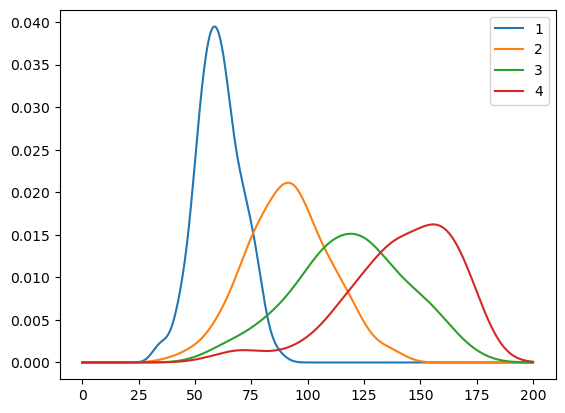

In [145]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

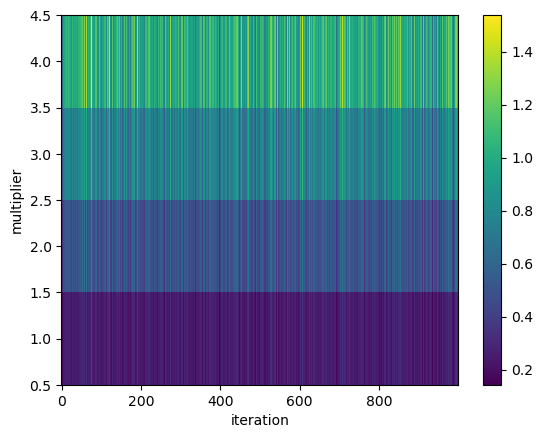

In [54]:
noise_bs_xr.plot()

In [55]:
sn_bs_xr.plot(hue='iteration', add_legend=False);

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 3 dimensions

In [ ]:
signal_bs_xr.plot(hue='iteration', add_legend=False);

In [ ]:
trend_series.plot(hue='iteration', add_legend=False);

In [ ]:
noise_series_xr.plot(hue='iteration', add_legend=False);

In [ ]:
noise_series_list.shape

In [ ]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [ ]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length=base_period.length+1)

In [711]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).isel(**ensemble_kwargs).values)

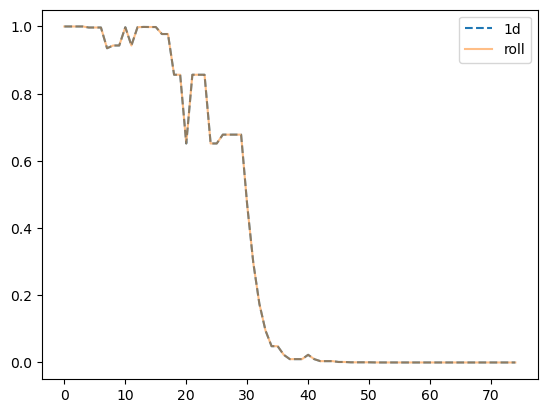

In [712]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2)), **ensemble_kwargs).values, label='roll', alpha=0.5)
plt.legend()